# Variational classifier

We know that there are parametrisable circuits. These circuit have gates that have themselves parameters that one can tune before executing the circuit. For example, an $RZ$ gate have a rotation parameter, that one can tune using its program.  
Having parameters in our circuit allows us to make adjustements in the way the circuit behave depending on the last output of this circuit. This process is the basis of machine learning.  
Having a parametrised circuit is equivalent to preparing a state $|\psi(x;\theta)\rangle$ in the circuit, with (in the context of machine learning) $x$ being our feature vector and $\theta$ being the parameters you can tune in the circuit.  
To better understand the parameters, we will look at an example : 

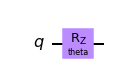

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

theta = Parameter('theta')#we define a parameter theta that one can tune

qc = QuantumCircuit(1)
qc.rz(theta,0)#we add an Rz gate to our circuit with the parameter theta controlling the rotation.
qc.draw(output = 'mpl')

Now that we have setup our parameter, we can tune it :

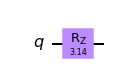

In [2]:
binded = qc.bind_parameters({theta : 3.14})#binding a parameter generates a new circuit.
binded.draw(output = 'mpl')

## Getting closer to machine learning

What the gates we saw before allows us to do is to tune the behavior of a circuit depending on its output. This is the way machine learning work. 
So now that we know how to make a circuit "learn", how do we execute it in practice ?

The pipeline will look like this : 
<img src='ressource/va.svg'/>
A circuit with parameter will be executed on a quantum backend, then a cost function (usually an adaptation of the least square) is computed on a classical backend and these result are fed back to the parameters of the circuit and the circuit is executed again. The learning phase ends when the whole training dataset has been covered. Thus the size of the training dataset is an hyper parameter that can lead to overfitting.

The **VQC** algorithm, is decomposed like so : 
<img src='ressource/vqc.svg'/>

Our feature ($\vec{\mathcal{X}}$) is given in parameter of the feature map $\phi$ to encode it and put it in a bigger Hilbert space. Then another variational circuit is applied,$\mathcal{W}$, with the parameter $\theta$. $\theta$ is the learning parameter, it can either be chosen at random, or an estimation can be given if the user already knows where to start.

Measuring this circuit outputs us a vector $\hat{\mathcal{Y}}$, that can be fed into the cost function. Once this cost function as been computed, we can either apply a gradient descent or any optimizer that we want to compute a new set of parameters $\theta$ that will be fed to the variational part of the circuit, execution the circuit again with the next feature vector.
  

## How to optimize the parameters

Usually in machine learning, the parameters $\theta$ are optimized with the gradient descent and considering the output of the cost function.  
The cost function usually used is the mean squared error function : 
$$\frac{1}{n}\sum_{i=0}^n(y-y')^2$$
where $n$ is the amount of feature vector, $y$ is the predicted output of our circuit and $y'$ is the expected output.  
Another cost function (used by default in qiskit's VQC algorithm) is the cross-entropy loss function : 
$$-\frac{1}{n}\sum_{i = 1}^n[y'ln(y)+(1-y')ln(1-y)]$$
with the same notations as above.  
Once this cost function has been computed, the result is given to an optimizer. The usual optimizer in machine learning is called the **gradient descent algorithm**, but some other, like **SPSA** will be presented below.

## Gradient descent
Hence we have a cost function $C$, the goal of machine learning is to minimize the minimize the cost function relative to the input $x$ and the parameters $\theta$.  
In order to achieve this, one must compute the gradient of the objective function. Once this gradient is computed, we would like to move our $\theta$ so that the cost function's evaluation is decreasing. Once we determined how much we wanted to move our parameters $\theta$, we can apply the formula : 
$$\theta_{i} := \theta_i - \mu \frac{\partial}{\partial\theta_i}C(\theta_i,x)$$
where $\theta_i$ is the i-th entry of the $\theta$ vector, $\mu$ is the learning rate (how much we will move at each iteration of the gradient descent) and $\frac{\partial}{\partial\theta_i}$ is the partial derivative over $\theta_i$. Repeating this process over all the entry of $\theta$ moves our vector towards a local minima.  
Finding a global minima is up to the learning rate : 
<img src='ressource/learningrate.png' />
with $J(\theta)$ being another name for the cost function. This example is in the case of a machine learning model with a single parameter.

## SPSA (Simultaneous Perturbation Stochastic Approximation)
SPSA has two main avantages : we dont need to compute the derivative of the cost function to use it (nor the gradient) and the algorithm is noise tolerant (perfect for the NISQ devices).  
There is also a non negligible difference in the amount of evaluation required for each step. While the gradient descent algorithm requires $2p$ evaluations of the cost function, with $p$ being the amount of parameters to optimize, SPSA only requires $2$ evaluations per iterations.  
Indeed, the formula for the update of the vector $\theta_i$ is : 
$$\theta_i = \theta_i - a_i\hat{g}_i(\theta_i)$$
with $a_i = \frac{a}{(A+i)^\alpha}$ and $c_i = \frac{c}{i^\gamma}$. Thus, $a$,$A$,$\alpha$, $c$ and $\gamma$ are hyper parameters that contribute (like the learning rate of the gradient descent) to the speed and the precision of the SPSA algorithm.  
The vector $\hat{g}_i(\theta_i)$ is defined like so : 
$$\hat{g}_{ik}(\theta_i) = \frac{y(\theta_i+c_i\Delta_i)-y(\theta_i-c_i\Delta_i)}{2c_i\Delta_{ik}}$$
for $k \in [1,p]$,$p$ the length of the vector $\theta$, $\Delta_i = (\Delta_{i1},\dots,\Delta_{ip})$ a vector of random variations (the best way to generate these variations is to use a Bernoulli distribution with the values {-1,+1}.
In term of comparaison, here is a visual representation of gradient descent and the SPSA algorithm :
<img src='ressource/spsa.png' width = "300"/>
We can note that this image represents the optimization of a maximisation problem, which both method are able to do.  
We can understand that, as the behavior of SPSA is erratic, it isnt a problem for this algorithm to be used in a noisy system.

In [1]:
from qiskit.utils import algorithm_globals
from qiskit import BasicAer, Aer
import numpy as np
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import *
from qiskit.algorithms.optimizers import *
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from utils import *
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pylab
from qiskit_machine_learning.algorithms.classifiers import VQC
import time

encoder = OneHotEncoder()#Encoder object to transform the label vector into a one hot vector

def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    #Function to plot the convergence of the optimizer
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

In [2]:
#Seed setup for results in accordance with the vqc notebook
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)


#Ad hoc data : Qiksit generates data. The training set has 20 feature vector with 2 feature each and the testing set has 
#10 feature vector (also with 2 features each).
train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=10, n=2, gap=0.3, one_hot=False))

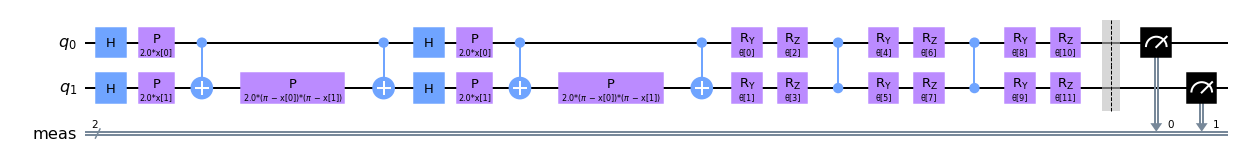

In [3]:

#In the vqc pipeline, we use a ZZFeatureMap to encode the data and a Twolocal circuit to allow variation.
#Note that any circuit with parameter can be used for both the encoding and the variational part
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
adhoc_var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

adhoc_circuit = adhoc_feature_map.compose(adhoc_var_form)
adhoc_circuit.measure_all()
adhoc_circuit.decompose().draw(output = 'mpl')

In [4]:
#Transformation of the label vector into a one hot vector
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()
print("train_labels_oh :",train_labels_oh.shape)

train_labels_oh : (40, 2)


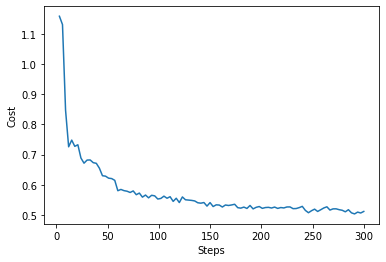

In [5]:

parameters = []
costs = []
evaluations = []

#initial_point = np.random.random(adhoc_var_form.num_parameters)
# initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
#                           0.96566328, 0.38243769, 0.90403094,
#                           0.82271449, 0.26810137, 0.61076489,
#                           0.82301609, 0.11789148, 0.29667125])


#The cost function used (here called loss) is the cross entropy (more stable and better to find a global minima)
#The optimizer used is SPSA for its resistance to noise and its ability to find a global minima
vqc = VQC(feature_map=adhoc_feature_map,
          ansatz=adhoc_var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(train_data, train_labels_oh)


#Plotting of the evolution of the cost function evaluation throughout the steps
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()


In [6]:
#Scoring of the training : How much of the test data has been recognized correctly
vqc.score(test_data, test_labels_oh)

0.95

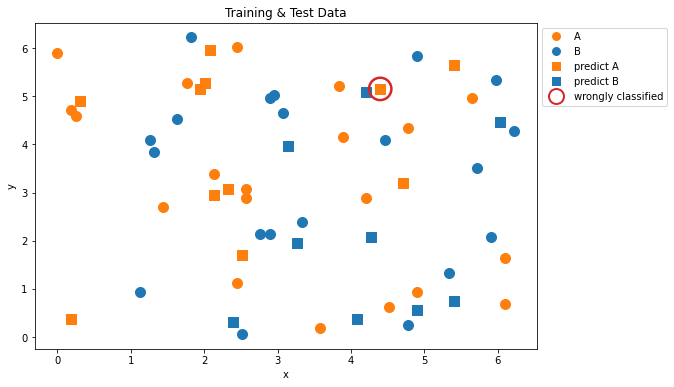

In [7]:
#This cell is only used for the representation of the training and testing datasets and to see the classification 
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels_oh):
    color = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=color)
    
for feature, label, pred in zip(test_data, test_labels_oh,
                                vqc.predict(test_data)): 
    color = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=color)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


(784,)
(1000, 784)
0


(1000, 49)

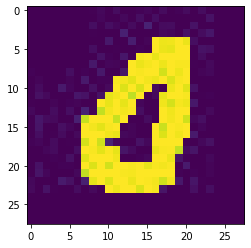

In [21]:
#Test on the PCA feature
pca = PCA(n_components=49)
train_data, train_label = import_full_image(howmuch=100)
print(np.array(train_data[1]).shape)
print(np.array(train_data).shape)
plt.imshow(np.array(train_data[1]).reshape(28,28))
print(train_label[1])
plt.plot()
newdata = pca.fit_transform(train_data)
newdata.shape


[]

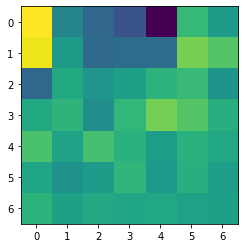

In [22]:
plt.imshow(newdata[1].reshape(7,7))
plt.plot()

In [23]:
#Test on learning with the SVC algorithm after using the PCA
svc = SVC()
svc.fit(newdata,train_label)

test_data,test_label = import_full_image(howmuch=100,imtype="Testing")
test_data = pca.fit_transform(test_data)
svc.score(test_data,test_label)

0.982

In [2]:
from qiskit import Aer


image_feature_map = EfficientSU2(num_qubits=5,reps = 4, parameter_prefix="in")
image_var_form = TwoLocal(5, ['ry', 'rz'], 'cz', reps=2)

#Importing 15 images of number ranging from 0 to 9 (150 images total)
train_data_image,train_label_image = import_full_image(howmuch = 15)
pca = PCA(n_components=50)
train_data_image = pca.fit_transform(train_data_image)
train_data_image , train_label_image = np.array(train_data_image), np.array(train_label_image)
train_labels_oh_image = encoder.fit_transform(train_label_image.reshape(-1, 1)).toarray()

parameters = []
costs = []
evaluations = []

weights_evol = []
eval_evol = []

def vqc_callback(current_weights,obj_eval):
    weights_evol.append(current_weights)
    eval_evol.append(eval_evol)



# optimizer=SPSA(callback=store_intermediate_result),
vqc = VQC(feature_map=image_feature_map,
          ansatz=image_var_form,
          loss='cross_entropy',
          optimizer = COBYLA(),
          quantum_instance=Aer.get_backend('qasm_simulator'),
          callback=vqc_callback)

vqc.fit(train_data_image, train_labels_oh_image)

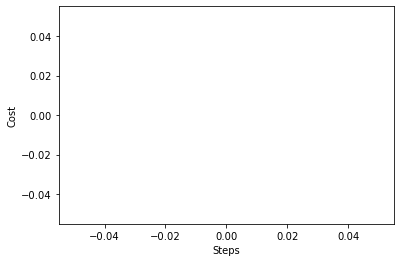

In [3]:
#Only available with SPSA
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
#VQC evolution
plt.plot(range(len(eval_evol)),eval_evol)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
test_data_image, test_label_image = import_full_image(imtype="Testing", howmuch=10)
test_data_image = pca.fit_transform(test_data_image)
test_label_image_oh = encoder.fit_transform(np.array(test_label_image).reshape(-1,1)).toarray()
vqc.score(test_data_image,test_label_image_oh)

# Test depending on the feature map and the variational form used

In [3]:
#Full on batch test (very long to execute)
from qiskit.circuit.library import *
from qiskit.algorithms.optimizers import *

feature_map_list = [TwoLocal(num_qubits = 5, reps = 4, rotation_blocks=['ry','rz'], entanglement_blocks='cz',parameter_prefix='in'),
                    RealAmplitudes(5, reps = 9,parameter_prefix='in'),
                    EfficientSU2(num_qubits = 5, reps = 4,parameter_prefix='in'),
                   ]

var_form_list = [TwoLocal(num_qubits = 5, reps = 2, rotation_blocks=['ry','rz'], entanglement_blocks='cz'),
                 PauliTwoDesign(num_qubits=5,reps = 2),
                 RealAmplitudes(5, reps = 2),
                 EfficientSU2(num_qubits = 5, reps = 2),
                 PauliFeatureMap(5),
                 ZFeatureMap(5),
                 ZZFeatureMap(5)
                ]
full_list = []
#Feature map and variational circuit variation
for feature_map in feature_map_list:
    for var_form in var_form_list:
        full_list.append((feature_map,var_form))
#Training data
train_data_image,train_label_image = import_full_image(howmuch = 15)
pca = PCA(n_components=50)
train_data_image = pca.fit_transform(train_data_image)
train_data_image , train_label_image = np.array(train_data_image), np.array(train_label_image)
train_labels_oh_image = encoder.fit_transform(train_label_image.reshape(-1, 1)).toarray()
#Testing data
test_data_image, test_label_image = import_full_image(imtype="Testing", howmuch=10)
test_data_image = pca.fit_transform(test_data_image)
test_label_image_oh = encoder.fit_transform(np.array(test_label_image).reshape(-1,1)).toarray()
full_list

[(<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7ac0>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.n_local.pauli_two_design.PauliTwoDesign at 0x1f6840b7b80>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes at 0x1f685711d60>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 at 0x1f685711610>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap at 0x1f6857117c0>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0x1f6840b7b20>,
  <qiskit.circuit.library.data_preparation.z_feature_map.ZFeatureMap at 0x1f685718f40>),
 (<qiskit.circuit.library.n_local.two_local.TwoLocal at 0

In [19]:
score_list = []
training_time_list = []
testing_time_list = []
for (feature_map,var_form) in full_list:
    print("Execution start for feature map ",feature_map.name," and variational form ",var_form.name)
    vqc = VQC(feature_map= feature_map,
             ansatz=var_form,
             loss='cross_entropy',
             optimizer=SPSA(),
             quantum_instance=BasicAer.get_backend('qasm_simulator'))
    start = time.time()
    vqc.fit(train_data_image,train_labels_oh_image)
    end = time.time()
    training_time_list.append(end-start)
    start = time.time()
    score_list.append(vqc.score(test_data_image,test_label_image_oh))
    end = time.time()
    testing_time_list.append(end-start)
    print("Execution end for feature map ",feature_map.name," and variational form ",var_form.name)
score_list,training_time_list,testing_time_list = np.array(score_list),np.array(training_time_list),np.array(testing_time_list)
np.save("score_list.npy",score_list)
np.save("training_time_list.npy",training_time_list)
np.save("testing_time_list.npy",testing_time_list)


Execution start for feature map  TwoLocal  and variational form  TwoLocal
Execution end for feature map  TwoLocal  and variational form  TwoLocal
Execution start for feature map  TwoLocal  and variational form  PauliTwoDesign
Execution end for feature map  TwoLocal  and variational form  PauliTwoDesign
Execution start for feature map  TwoLocal  and variational form  RealAmplitudes
Execution end for feature map  TwoLocal  and variational form  RealAmplitudes
Execution start for feature map  TwoLocal  and variational form  EfficientSU2
Execution end for feature map  TwoLocal  and variational form  EfficientSU2
Execution start for feature map  TwoLocal  and variational form  PauliFeatureMap
Execution end for feature map  TwoLocal  and variational form  PauliFeatureMap
Execution start for feature map  TwoLocal  and variational form  ZFeatureMap
Execution end for feature map  TwoLocal  and variational form  ZFeatureMap
Execution start for feature map  TwoLocal  and variational form  ZZFeatu

In [22]:
(sum(training_time_list)+sum(testing_time_list))/3600

5.167661670976215

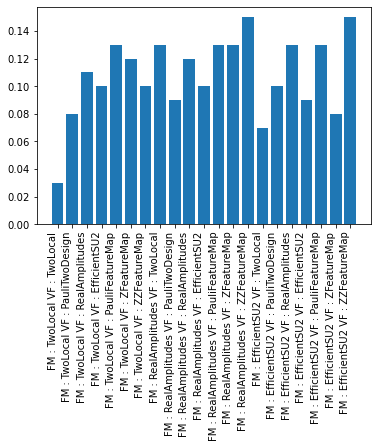

In [36]:
name_list = ['FM : '+ i[0].name + ' VF : '+i[1].name for i in full_list]
fig,ax = plt.subplots()
ax.bar(name_list,score_list)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

# Conclusion : No combination perform better than the other, but there are some that perform way worse

In [48]:
almostnotrandom = [(ind,i) for ind,i in enumerate(score_list) if i >= 0.1]
almostnotrandomname = [name_list[i[0]] for i in almostnotrandom]
almostnotrandomname

['FM : TwoLocal VF : RealAmplitudes',
 'FM : TwoLocal VF : EfficientSU2',
 'FM : TwoLocal VF : PauliFeatureMap',
 'FM : TwoLocal VF : ZFeatureMap',
 'FM : TwoLocal VF : ZZFeatureMap',
 'FM : RealAmplitudes VF : TwoLocal',
 'FM : RealAmplitudes VF : RealAmplitudes',
 'FM : RealAmplitudes VF : EfficientSU2',
 'FM : RealAmplitudes VF : PauliFeatureMap',
 'FM : RealAmplitudes VF : ZFeatureMap',
 'FM : RealAmplitudes VF : ZZFeatureMap',
 'FM : EfficientSU2 VF : PauliTwoDesign',
 'FM : EfficientSU2 VF : RealAmplitudes',
 'FM : EfficientSU2 VF : PauliFeatureMap',
 'FM : EfficientSU2 VF : ZZFeatureMap']

In [50]:
almostthere = [(ind,i) for ind,i in enumerate(score_list) if i < 0.1 and i >=0.08]
almosttherename = [name_list[i[0]] for i in almostthere]
almosttherename

['FM : TwoLocal VF : PauliTwoDesign',
 'FM : RealAmplitudes VF : PauliTwoDesign',
 'FM : EfficientSU2 VF : EfficientSU2',
 'FM : EfficientSU2 VF : ZFeatureMap']

In [51]:
verybad =  [(ind,i) for ind,i in enumerate(score_list) if i < 0.08]
verybadname = [name_list[i[0]] for i in almostthere]
verybadname

['FM : TwoLocal VF : PauliTwoDesign',
 'FM : RealAmplitudes VF : PauliTwoDesign',
 'FM : EfficientSU2 VF : EfficientSU2',
 'FM : EfficientSU2 VF : ZFeatureMap']

# Test on the amount of images given to the best combo

In [4]:
score_list = np.load("score_list.npy")
best_combo = full_list[(score_list.tolist()).index(max(score_list))]
best_combo

(<qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes at 0x1f6856c36d0>,
 <qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap at 0x1f685711850>)

In [5]:
train_data_list = []
train_label_list = []
#The amount of image grows from 50 to 500 with a step of 50
for amount in range(5,200,5):
    train_data,train_label = import_full_image(howmuch=amount)
    pca = PCA(n_components=50)
    train_data = pca.fit_transform(train_data)
    train_data , train_label = np.array(train_data), np.array(train_label)
    train_labels_oh = encoder.fit_transform(train_label.reshape(-1, 1)).toarray()
    train_data_list.append(train_data)
    train_label_list.append(train_labels_oh)

In [6]:
np.save("train_data_list.npy",train_data_list)
np.save("train_label_list.npy",train_label_list)
#Do not mind the warning, works anyway (thats some good programming habits right there)

C:\Users\108997706\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
#execution until 1750 images took 2.9 days. I dont recommend running this cell
train_time_amount_list = []
test_time_amount_list = []
score_amount_list = []
feature_map = best_combo[0]
var_form = best_combo[1]
for train_data,train_label in zip(train_data_list,train_label_list):
    print("Execution start for ",len(train_data), " images")
    vqc = VQC(feature_map= feature_map,
             ansatz=var_form,
             loss='cross_entropy',
             optimizer=SPSA(),
             quantum_instance=BasicAer.get_backend('qasm_simulator'))
    start = time.time()
    vqc.fit(train_data,train_label)
    end = time.time()
    train_time_amount_list.append(end-start)
    start = time.time()
    score_amount_list.append(vqc.score(test_data_image,test_label_image_oh))
    end = time.time()
    test_time_amount_list.append(end-start)
    print("Execution end for ",len(train_data)," images")

Execution start for  50  images
Execution end for  50  images
Execution start for  100  images
Execution end for  100  images
Execution start for  150  images
Execution end for  150  images
Execution start for  200  images
Execution end for  200  images
Execution start for  250  images
Execution end for  250  images
Execution start for  300  images
Execution end for  300  images
Execution start for  350  images
Execution end for  350  images
Execution start for  400  images
Execution end for  400  images
Execution start for  450  images
Execution end for  450  images
Execution start for  500  images
Execution end for  500  images
Execution start for  550  images
Execution end for  550  images
Execution start for  600  images
Execution end for  600  images
Execution start for  650  images
Execution end for  650  images
Execution start for  700  images
Execution end for  700  images
Execution start for  750  images
Execution end for  750  images
Execution start for  800  images
Execution

KeyboardInterrupt: 

In [2]:
score_amount = np.load("score_amount.npy")
train_time_amount = np.load("train_time_amount.npy")
test_time_amount = np.load("test_time_amount.npy")

In [16]:
print("Total execution time (days)",(sum(train_time_amount)+sum(test_time_amount))/3600/24)
print("Max execution time for an iteration (hours)", max(train_time_amount)/3600," for ",50*train_time_amount.tolist().index(max(train_time_amount))+50," images")
print("Maximum score for an iteration : ",max(score_amount)," for ",50*score_amount.tolist().index(max(score_amount))+50," images")

Total execution time (days) 2.9324234429608893
Max execution time for an iteration (hours) 3.85413464181953  for  1750  images
Maximum score for an iteration :  0.14  for  300  images


In [22]:
sort_index = np.argsort(score_amount)
score_sorted = np.flip(score_amount[sort_index])
amount_sorted = np.flip(np.array([i for i in range(50,1800,50)])[sort_index])

print("Score in comparaison of the amount of images used to train vqc : \n",list(zip(score_sorted,amount_sorted)))

Score in comparaison of the amount of images used to train vqc : 
 [(0.14, 300), (0.13, 1750), (0.13, 750), (0.12, 400), (0.12, 450), (0.12, 1700), (0.12, 500), (0.12, 1050), (0.12, 700), (0.11, 1500), (0.11, 350), (0.1, 1150), (0.1, 1450), (0.09, 250), (0.09, 1200), (0.09, 1300), (0.09, 950), (0.09, 850), (0.09, 200), (0.08, 150), (0.08, 650), (0.08, 900), (0.08, 1000), (0.08, 1100), (0.08, 1250), (0.07, 1350), (0.07, 1550), (0.07, 1650), (0.07, 100), (0.06, 800), (0.06, 600), (0.06, 550), (0.06, 1400), (0.06, 50), (0.05, 1600)]


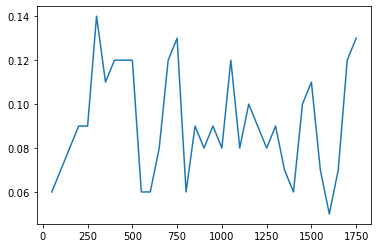

In [23]:
plt.plot([i for i in range(50,1800,50)],score_amount)
plt.show()

# Conclusion : I regret taking a weekend to run that

# Trying with another dataset with less features

In [40]:
import pandas as pd

cov_dict = pd.read_csv('covid.csv').to_dict()

In [41]:
cov_dict.keys()

dict_keys(['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male', 'Gender_Transgender', 'Severity_Mild', 'Severity_Moderate', 'Severity_None', 'Severity_Severe', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes', 'Country'])

In [42]:
cov_dict.pop('Severity_Mild',None)
cov_dict.pop('Severity_Moderate',None)
cov_dict.pop('Severity_None',None)
cov_dict.pop('Country',None);

In [43]:
cov_dict.keys()

dict_keys(['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male', 'Gender_Transgender', 'Severity_Severe', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes'])

In [44]:
y = cov_dict.pop('Severity_Severe',None)
x = cov_dict

In [45]:
y_list = np.array(list(y.values()))
y_oh = encoder.fit_transform(y_list.reshape(-1, 1)).toarray()

In [46]:
import random
x_list = np.array([np.array([x.get(k)[i] for k in list(x.keys())]) for i in range(len(x.get('Fever')))])
enum = list(enumerate(x_list))
random.shuffle(enum)
index, _ = zip(*enum)

x_shuffle = x_list[index,:]
y_oh_shuffle = y_oh[index,:]

In [47]:
#Test with feature selection

from sklearn.feature_selection import SelectKBest, chi2
test = SelectKBest(score_func=chi2, k=20)
x_shuffle = test.fit_transform(x_shuffle,y_oh_shuffle)
np.set_printoptions(precision=3)
print("Score : ",test.scores_)
np.set_printoptions(precision = 8)


Score :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [48]:
x_shuffle.shape

(316800, 20)

In [53]:
train_data = x_shuffle[1000:1100]
train_label = y_oh_shuffle[1000:1100]
test_data = x_shuffle[210:400]
test_label = y_oh_shuffle[210:400]

In [50]:
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
def callback_opti(eva,param,value,stepsize,accept):
    clear_output(wait = True)
    value_obj.append(value)
    plt.title("Objective function in SPSA")
    plt.xlabel("Iteration")
    plt.ylabel("Objective value")
    plt.plot(range(len(value_obj)),value_obj)
    plt.plot(range(len(objective_func_vals)),objective_func_vals)
    plt.show()

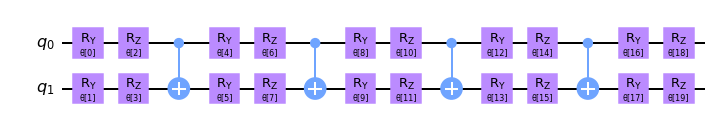

In [15]:
EfficientSU2(num_qubits=2,reps = 4).decompose().draw(output = 'mpl')

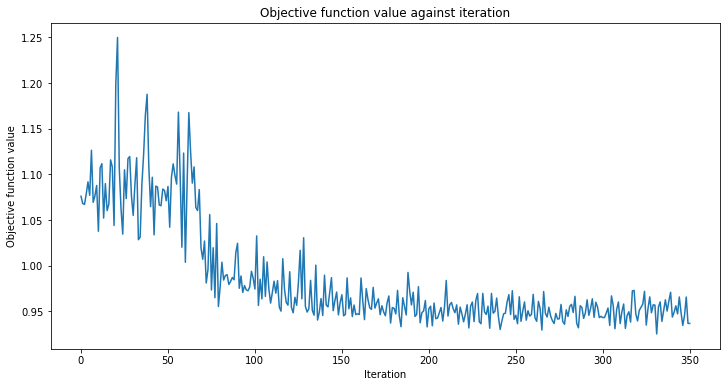

In [31]:
feature_map = EfficientSU2(num_qubits=2, reps = 4, parameter_prefix='in')
var_form = TwoLocal(num_qubits=feature_map.num_qubits, rotation_blocks=['ry','rz'], entanglement_blocks='cz')
# display(var_form.decompose().draw(output = 'mpl'))
objective_func_vals = []
value_obj = []
evaluations =[]
parameters = []
costs = []

plt.rcParams["figure.figsize"] = (12, 6)

initial_point = np.random.random(var_form.num_parameters)

optimizer = SPSA(maxiter=100,callback=store_intermediate_result)

vqc = VQC(feature_map= feature_map,
             ansatz=var_form,
             loss='cross_entropy',
             optimizer=optimizer,
             quantum_instance=Aer.get_backend('qasm_simulator'),
             initial_point=initial_point,
             callback=callback_graph)
vqc.fit(train_data,train_label)
# plt.plot(evaluations,costs)
# plt.xlabel("Evaluations")
# plt.ylabel("Costs")
# plt.show()

In [32]:
vqc.score(train_data,train_label)

0.68

In [64]:
# test with the noise of a real backend
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='support', project='core-team')

ibmqfactory.load_account:WARNING:2022-05-18 12:05:27,747: Credentials are already in use. The existing account in the session will be replaced.


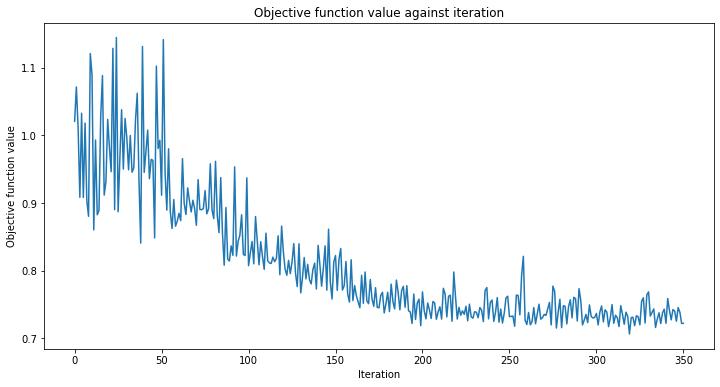

In [131]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils import QuantumInstance
backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(backend)
inst = QuantumInstance(backend = Aer.get_backend('qasm_simulator'), noise_model=noise_model)

objective_func_vals = []

optimizer = SPSA(maxiter=100,callback=store_intermediate_result)

vqc_noisy = VQC(feature_map= feature_map,
             ansatz=var_form,
             loss='cross_entropy',
             optimizer=optimizer,
             quantum_instance=inst,
             initial_point=initial_point,
             callback=callback_graph)
vqc_noisy.fit(train_data,train_label)

In [132]:
vqc_noisy.score(train_data,train_label)

0.74

In [65]:
#VQC runtime test
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q-internal',group = 'support',project='core-team')
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2022-05-18 12:05:37,661: Credentials are already in use. The existing account in the session will be replaced.


In [66]:
import os
program_json = os.path.join(os.getcwd(),"vqcruntime.json")
program_data = os.path.join(os.getcwd(),"vqcruntime.py")

In [38]:
program_id = provider.runtime.upload_program(
                                            data = program_data,
                                            metadata = program_json)
#id : vqcruntime-E9847vJ1W9
print("Programm id : ",program_id)
print(provider.runtime.program(program_id))

Programm id :  vqcruntime-E9847vJ1W9
vqcruntime-E9847vJ1W9:
  Name: vqcruntime
  Description: First try at runtime with vqc
  Creation date: 2022-05-16T14:09:35.000353Z
  Update date: 2022-05-16T14:09:35.000353Z
  Max execution time: 3600
  Input parameters:
    Properties:
        - train_data:
            Description: List of train data
            Type: list
            Required: True
        - train_label:
            Description: List of train labels, in one hot vector form
            Type: list
            Required: True
  Interim results:
    Properties:
        - cost:
            Description: The evolution of the cost function
            Type: list
            Required: False
  Returns:
    Description: List of weights trained by vqc. Can be used with the warm start parameter of vqc
    Type: list


In [67]:
program_id = "vqcruntime-E9847vJ1W9"
provider.runtime.update_program(program_id= program_id,data = program_data,metadata=program_json)

In [1]:

def interim_result(job_id,interim_result):
    c = interim_result['cost']
    from IPython.display import clear_output
    clear_output(wait=True)
    objective_func_vals.append(c)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(c)), c)
    plt.show()

In [2]:
from qiskit.tools.jupyter import job_watcher
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [69]:
provider = IBMQ.get_provider(group = 'open')
backend = provider.get_backend('ibmq_belem')

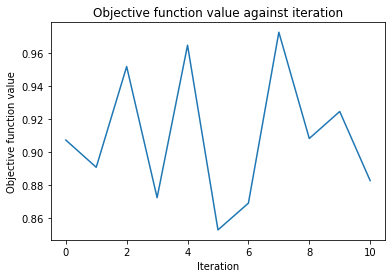

In [ ]:
objective_func_vals = []
program_inputs = {
    'train_data':train_data,'train_label':train_label, 'test_data':test_data, 'test_label':test_label
}
options = {'backend_name' : backend.name()}
job = provider.runtime.run(program_id=program_id,
                          options = options,
                          inputs = program_inputs,
                          callback=interim_result)
result = job.result()

In [ ]:
result